In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from tzlocal import get_localzone

from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
import osisoft.pidevclub.piwebapi

user= #USER
pw = #PASSWORD
from osisoft.pidevclub.piwebapi.pi_web_api_client import PIWebApiClient  
client = PIWebApiClient('https://NAME_DIR/piwebapi', False, user, pw, False) #não dobrar as barras
path = 'pi:\\\\NAME_DIR_LOCAL\\'

### Ler tags para avaliação + Pré-processamento

In [4]:
list_tags = ['B6OPT_ROLO','B6FPGRADE','QUEBRAS_MB6_HST',
             'B6OPT_119_AVG','B6OPT_120_AVG','B6RIGIDEZ_L_FRC','B6RIGIDEZ_T_FRC']

paths = []

for tag in list_tags:
    paths.append(path + tag)

In [5]:
#o modelo com regressão linear passou a ser utilizado na terça-feira (21/04), pouco antes de de meia-noite
#subtração de 20 pontos na rigidez L a partir de 01/05, meia noite
df = client.data.get_multiple_interpolated_values(paths, start_time = '2020-05-01T03:00:00.0450585Z', 
                                                  end_time = '*',interval = '45m')

print('OK!')

OK!


In [6]:
#selecionar apenas as colunas de valores e uma coluna de Timestamp
numbers = np.arange(1,8,1)
value = 'Value'
list_values = ['Timestamp1']
for number in numbers:
    list_values.append(value + str(number))
df = df.loc[:,list_values]

In [7]:
#renomear as colunas com nomes das tags
list_tags.insert(0,'TIMESTAMP')
df = df.rename(columns = dict(zip(list_values,list_tags)))

In [8]:
#equação de regressão de 21/04
#subtração de 20 pontos na rigidez L desde 01/05
df = df.rename(columns = {'B6RIGIDEZ_L_FRC': 'L_reglin','B6RIGIDEZ_T_FRC': 'T_reglin'})

df['B6RIGIDEZ_L_FRC'] = (df['L_reglin'] - 11.8311679 + 20.0)/(0.98164837)
df['B6RIGIDEZ_T_FRC'] = (df['T_reglin'] - 8.50177516)/(0.94711796)

In [9]:
#excluir rolos repetidos - o valor aleatório deve representar o rolo 
idx = df.index.to_list()
rows_to_drop = []

for i in idx:
    if i == 0:
        pass
    else:
        if df.B6OPT_ROLO[i] == df.B6OPT_ROLO[i-1]:
            rows_to_drop.append(i)
            
df = df.drop(rows_to_drop, axis = 'rows')            

In [10]:
#definir família
df['LINHA'] = df['B6FPGRADE'].str[0:3]

#excluir períodos de quebra
df = df[df['QUEBRAS_MB6_HST'] == 0]

#excluir valores duvidosos
df = df[df['B6OPT_120_AVG'] <= 200]

### Funções para Avaliação

In [11]:
def bias_reglin_L(pred,y_test):

    df_L = pd.DataFrame(data = {'L_true': list(y_test['B6OPT_119_AVG'].values),
                                'L_pred': list(pred['B6RIGIDEZ_L_FRC'].values)})
    
    model_L = LinearRegression().fit(df_L[['L_true']], df_L[['L_pred']])
    
    L_reglin = model_L.coef_[0][0]*df_L[['L_true']] + model_L.intercept_[0]
    
    #print(model_L.coef_,model_L.intercept_)
    
    r2_L = r2_score(df_L[['L_true']],L_reglin)
    
    r2_L_pr = r2_score(df_L[['L_true']],df_L[['L_pred']])

    return r2_L, r2_L_pr, L_reglin

In [12]:
def bias_reglin_T(pred,y_test):

    df_T = pd.DataFrame(data = {'T_true': list(y_test['B6OPT_120_AVG'].values),
                                'T_pred': list(pred['B6RIGIDEZ_T_FRC'].values)})
    
    model_T = LinearRegression().fit(df_T[['T_true']], df_T[['T_pred']])
    
    T_reglin = model_T.coef_[0][0]*df_T[['T_true']] + model_T.intercept_[0]
    
    #print(model_T.coef_,model_T.intercept_)
    
    r2_T = r2_score(df_T[['T_true']],T_reglin)
    
    r2_T_pr = r2_score(df_T[['T_true']],df_T[['T_pred']])

    return r2_T, r2_T_pr, T_reglin

In [13]:
def score_RMSE_pred (pred,y_test):
    
    RMSE_L = np.sqrt(mean_squared_error( y_test['B6OPT_119_AVG'],pred['B6RIGIDEZ_L_FRC'])) #LONGITUDINAL
    RMSE_T = np.sqrt(mean_squared_error(y_test['B6OPT_120_AVG'],pred['B6RIGIDEZ_T_FRC'])) #TRANSVERSAL
        
    return RMSE_L, RMSE_T

In [14]:
def score_RMSE_reglin (pred,y_test):
    
    RMSE_L = np.sqrt(mean_squared_error(y_test['B6OPT_119_AVG'],pred['L_reglin'])) #LONGITUDINAL
    RMSE_T = np.sqrt(mean_squared_error(y_test['B6OPT_120_AVG'],pred['T_reglin'])) #TRANSVERSAL
        
    return RMSE_L, RMSE_T

### Avaliação Geral e por Spec-fam

#### Avaliação Geral

Avaliação Geral


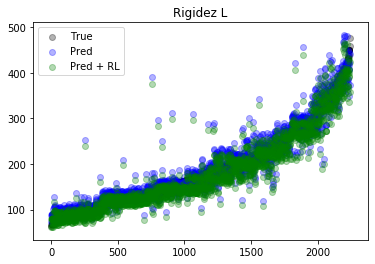

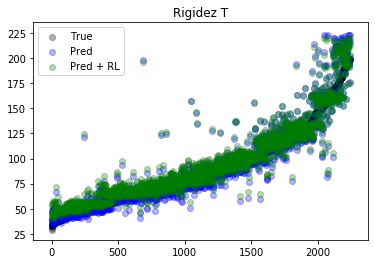

R2 SEM RL:	 0.9279 (L)	 0.902 (T)
R2 COM RL:	 0.9985 (L)	 0.9958 (T)
RMSE SEM RL:	 23.07 (L)	 12.13 (T)
RMSE COM RL:	 24.88 (L)	 12.8 (T)


In [18]:
print('Avaliação Geral')

#Gráfico Rigidez L
df2 = df.sort_values(by = ['B6OPT_119_AVG'],ascending = True)
df2 = df2.reset_index()

plt.scatter(df2.index,df2['B6OPT_119_AVG'],color = 'k', alpha  = 0.3, label = 'True')
plt.scatter(df2.index,df2['B6RIGIDEZ_L_FRC'], color = 'b', alpha  = 0.3, label = 'Pred')
plt.scatter(df2.index,df2['L_reglin'], color = 'g',alpha  = 0.3,label = 'Pred + RL')

plt.title('Rigidez L')
plt.legend()
plt.show()

#Gráfico Rigidez T
df2 = df.sort_values(by = ['B6OPT_120_AVG'],ascending = True)
df2 = df2.reset_index()

plt.scatter(df2.index,df2['B6OPT_120_AVG'],color = 'k',alpha  = 0.3,label = 'True')
plt.scatter(df2.index,df2['B6RIGIDEZ_T_FRC'], color = 'b',alpha  = 0.3,label = 'Pred')
plt.scatter(df2.index,df2['T_reglin'], color = 'g',alpha  = 0.3,label = 'Pred + RL')

plt.title('Rigidez T')
plt.legend()
plt.show()

#R2
r2_L, r2_L_pr, L_reglin = bias_reglin_L(df,df)
r2_T, r2_T_pr, T_reglin = bias_reglin_T(df,df)

print('R2 SEM RL:\t',round(r2_L_pr,4),'(L)\t',round(r2_T_pr,4),'(T)')
print('R2 COM RL:\t',round(r2_L,4),'(L)\t',round(r2_T,4),'(T)')

#RMSE sem Regressão Linear
RMSE_L, RMSE_T = score_RMSE_pred (df,df)
print('RMSE SEM RL:\t',round(RMSE_L,2),'(L)\t', round(RMSE_T,2),'(T)')

#RMSE com Regressão Linear
RMSE_L, RMSE_T = score_RMSE_reglin (df,df)
print('RMSE COM RL:\t',round(RMSE_L,2),'(L)\t',round(RMSE_T,2),'(T)')

#### Avaliação por Família de Cartão

Avaliação por Família


Família: TWP


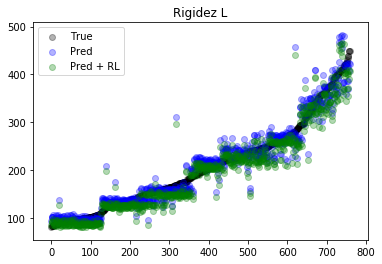

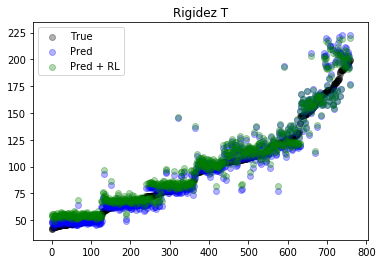

R2 SEM RL:	 0.9411 (L)	 0.9323 (T)
R2 COM RL:	 0.9994 (L)	 0.9958 (T)
RMSE SEM RL:	 21.96 (L)	 10.58 (T)
RMSE COM RL:	 24.4 (L)	 10.98 (T)

Família: TFP


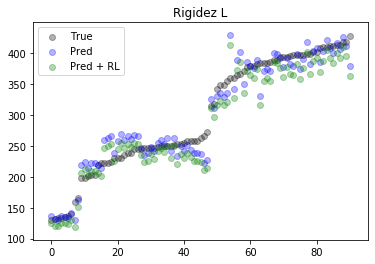

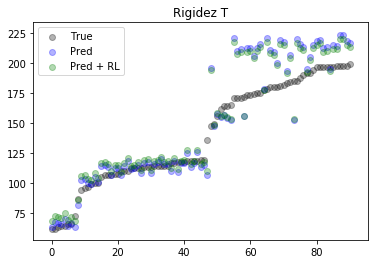

R2 SEM RL:	 0.9489 (L)	 0.7929 (T)
R2 COM RL:	 0.9973 (L)	 0.9089 (T)
RMSE SEM RL:	 20.24 (L)	 19.17 (T)
RMSE COM RL:	 24.52 (L)	 17.91 (T)

Família: TPS


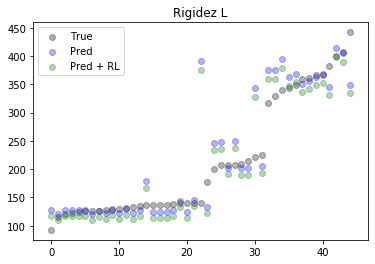

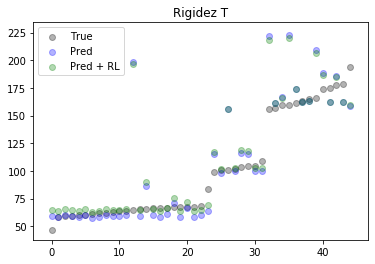

R2 SEM RL:	 0.7753 (L)	 0.6264 (T)
R2 COM RL:	 0.9862 (L)	 0.9765 (T)
RMSE SEM RL:	 49.21 (L)	 27.97 (T)
RMSE COM RL:	 47.35 (L)	 27.37 (T)

Família: S6N


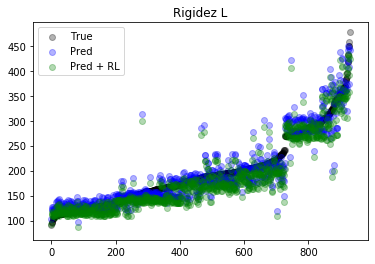

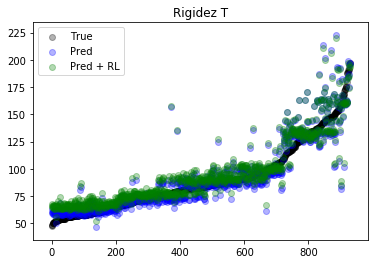

R2 SEM RL:	 0.8899 (L)	 0.8496 (T)
R2 COM RL:	 0.9994 (L)	 0.9954 (T)
RMSE SEM RL:	 23.06 (L)	 11.97 (T)
RMSE COM RL:	 25.88 (L)	 12.68 (T)

Família: SBA


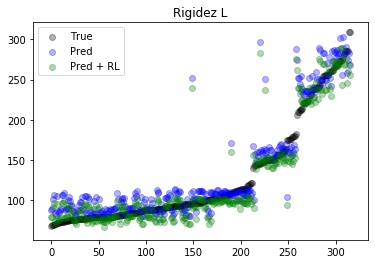

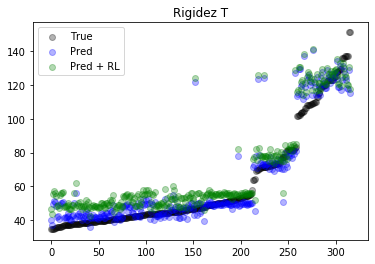

R2 SEM RL:	 0.8807 (L)	 0.8881 (T)
R2 COM RL:	 0.9796 (L)	 0.9907 (T)
RMSE SEM RL:	 21.97 (L)	 9.92 (T)
RMSE COM RL:	 19.81 (L)	 12.15 (T)

Família: TPW


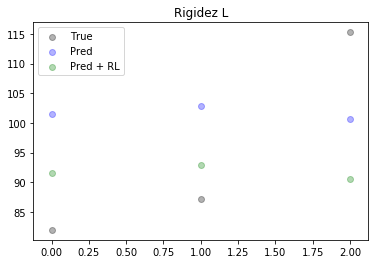

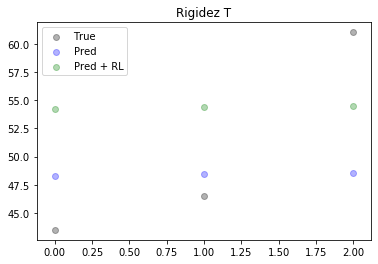

R2 SEM RL:	 -0.3181 (L)	 -0.0379 (T)
R2 COM RL:	 -0.3162 (L)	 -0.0379 (T)
RMSE SEM RL:	 16.77 (L)	 7.79 (T)
RMSE COM RL:	 15.61 (L)	 8.55 (T)

Família: DUO


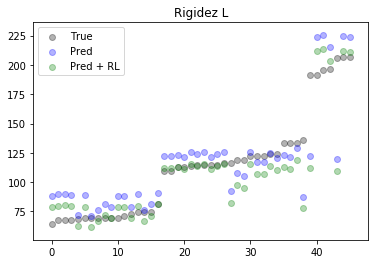

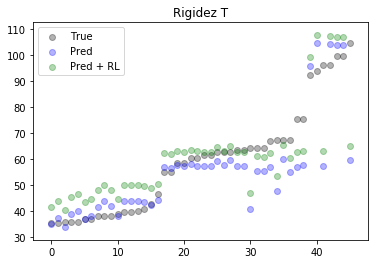

R2 SEM RL:	 0.7246 (L)	 0.6716 (T)
R2 COM RL:	 0.9632 (L)	 0.9084 (T)
RMSE SEM RL:	 22.62 (L)	 11.59 (T)
RMSE COM RL:	 23.36 (L)	 10.93 (T)

Família: BCC


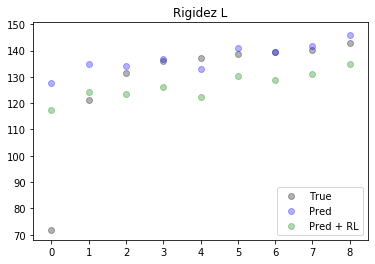

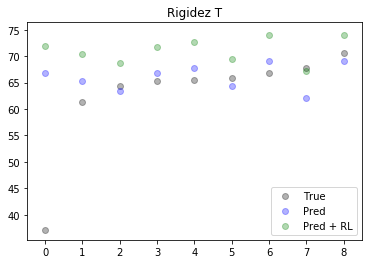

R2 SEM RL:	 0.1548 (L)	 -0.21 (T)
R2 COM RL:	 0.1792 (L)	 -0.1476 (T)
RMSE SEM RL:	 19.32 (L)	 10.3 (T)
RMSE COM RL:	 17.6 (L)	 12.82 (T)

Família: BCO


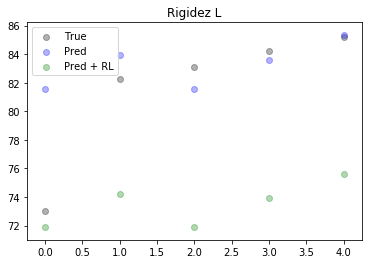

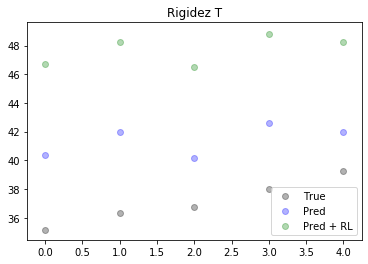

R2 SEM RL:	 0.1774 (L)	 -8.7643 (T)
R2 COM RL:	 0.2415 (L)	 -8.487 (T)
RMSE SEM RL:	 3.98 (L)	 4.43 (T)
RMSE COM RL:	 8.82 (L)	 10.66 (T)

Família: CBO


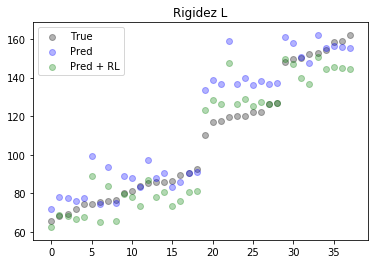

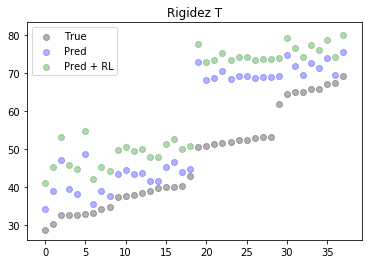

R2 SEM RL:	 0.8356 (L)	 0.2722 (T)
R2 COM RL:	 0.9351 (L)	 0.4802 (T)
RMSE SEM RL:	 12.74 (L)	 10.69 (T)
RMSE COM RL:	 10.05 (L)	 15.49 (T)


In [19]:
fams = df.LINHA.unique()
print('Avaliação por Família\n')

for i in fams: 
    
    df2 = df[df['LINHA']==i]
    
    print('\nFamília:',i)
    
    #Gráfico Rigidez L
    df2 = df2.sort_values(by = ['B6OPT_119_AVG'],ascending = True)
    df2 = df2.reset_index()

    plt.scatter(df2.index,df2['B6OPT_119_AVG'],color = 'k',alpha  = 0.3,label = 'True')
    plt.scatter(df2.index,df2['B6RIGIDEZ_L_FRC'], color = 'b',alpha  = 0.3,label = 'Pred')
    plt.scatter(df2.index,df2['L_reglin'], color = 'g',alpha  = 0.3,label = 'Pred + RL')

    plt.title('Rigidez L')
    plt.legend()
    plt.show()
    
    #Gráfico Rigidez T
    df2 = df2.sort_values(by = ['B6OPT_120_AVG'],ascending = True)
    df2 = df2.reset_index()

    plt.scatter(df2.index,df2['B6OPT_120_AVG'],color = 'k',alpha  = 0.3,label = 'True')
    plt.scatter(df2.index,df2['B6RIGIDEZ_T_FRC'], color = 'b',alpha  = 0.3,label = 'Pred')
    plt.scatter(df2.index,df2['T_reglin'], color = 'g',alpha  = 0.3,label = 'Pred + RL')

    plt.title('Rigidez T')
    plt.legend()
    plt.show()
    
    df2 = df[df['LINHA'] == i]
    
    r2_L, r2_L_pr, L_reglin = bias_reglin_L(df2,df2)
    r2_T, r2_T_pr, T_reglin = bias_reglin_T(df2,df2)
    
    #RMSE sem Regressão Linear
    RMSE_L, RMSE_T = score_RMSE_pred (df2,df2)
    
    #RMSE com Regressão Linear
    RMSE_L_rl, RMSE_T_rl = score_RMSE_reglin (df2,df2)

    print('R2 SEM RL:\t',round(r2_L_pr,4),'(L)\t',round(r2_T_pr,4),'(T)')
    print('R2 COM RL:\t',round(r2_L,4),'(L)\t',round(r2_T,4),'(T)')
    print('RMSE SEM RL:\t',round(RMSE_L,2),'(L)\t', round(RMSE_T,2),'(T)')
    print('RMSE COM RL:\t',round(RMSE_L_rl,2),'(L)\t',round(RMSE_T_rl,2),'(T)')


Família: Copos (BCO, CBO, BCC)


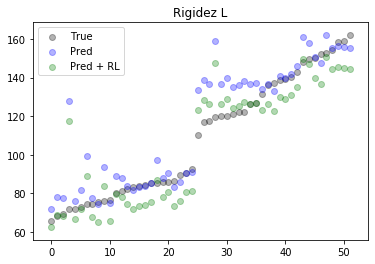

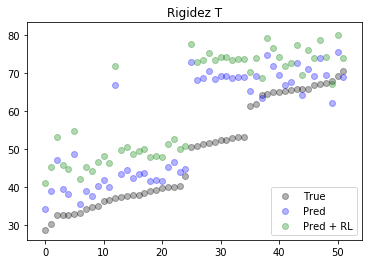

R2 SEM RL:	 0.8356 (L)	 0.2722 (T)
R2 COM RL:	 0.9351 (L)	 0.4802 (T)
RMSE SEM RL:	 12.74 (L)	 10.69 (T)
RMSE COM RL:	 10.05 (L)	 15.49 (T)


In [21]:
df2 = df[(df['LINHA']=='BCO') | (df['LINHA']=='CBO') | (df['LINHA']=='BCC')]
    
print('\nFamília: Copos (BCO, CBO, BCC)')
    
#Gráfico Rigidez L
df2 = df2.sort_values(by = ['B6OPT_119_AVG'],ascending = True)
df2 = df2.reset_index()

plt.scatter(df2.index,df2['B6OPT_119_AVG'],color = 'k',alpha  = 0.3,label = 'True')
plt.scatter(df2.index,df2['B6RIGIDEZ_L_FRC'], color = 'b',alpha  = 0.3,label = 'Pred')
plt.scatter(df2.index,df2['L_reglin'], color = 'g',alpha  = 0.3,label = 'Pred + RL')

plt.title('Rigidez L')
plt.legend()
plt.show()
    
#Gráfico Rigidez T
df2 = df2.sort_values(by = ['B6OPT_120_AVG'],ascending = True)
df2 = df2.reset_index()

plt.scatter(df2.index,df2['B6OPT_120_AVG'],color = 'k',alpha  = 0.3,label = 'True')
plt.scatter(df2.index,df2['B6RIGIDEZ_T_FRC'], color = 'b',alpha  = 0.3,label = 'Pred')
plt.scatter(df2.index,df2['T_reglin'], color = 'g',alpha  = 0.3,label = 'Pred + RL')

plt.title('Rigidez T')
plt.legend()
plt.show()
    
df2 = df[df['LINHA'] == i]
    
r2_L, r2_L_pr, L_reglin = bias_reglin_L(df2,df2)
r2_T, r2_T_pr, T_reglin = bias_reglin_T(df2,df2)
    
#RMSE sem Regressão Linear
RMSE_L, RMSE_T = score_RMSE_pred (df2,df2)
    
#RMSE com Regressão Linear
RMSE_L_rl, RMSE_T_rl = score_RMSE_reglin (df2,df2)

print('R2 SEM RL:\t',round(r2_L_pr,4),'(L)\t',round(r2_T_pr,4),'(T)')
print('R2 COM RL:\t',round(r2_L,4),'(L)\t',round(r2_T,4),'(T)')
print('RMSE SEM RL:\t',round(RMSE_L,2),'(L)\t', round(RMSE_T,2),'(T)')
print('RMSE COM RL:\t',round(RMSE_L_rl,2),'(L)\t',round(RMSE_T_rl,2),'(T)')